<a href="https://colab.research.google.com/github/thiagolermen/facemask-detection-v1/blob/main/FaceMaskDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Face Mask Detection

Masks play a crucial role in protecting the health of individuals against respiratory diseases, as is one of the few precautions available for COVID-19 in the absence of immunization. With this dataset, it is possible to create a model to detect people wearing mask or not wearing them..
This dataset contains 3824 images belonging to the 2 classes.
The classes are:

- With mask;
- Without mask;


##Import

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import PIL
import tensorflow as tf
import cv2
from keras.preprocessing.image import *
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

###Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


###Path to Kaggle

In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

In [4]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle/
#Check the present working directory using pwd command

/content/gdrive/My Drive/Kaggle


In [5]:
!kaggle datasets download -d thiagolermen/dataset-face-mask-detection

 90% 115M/127M [00:00<00:00, 164MB/s] 
100% 127M/127M [00:00<00:00, 152MB/s]


##Dataset

In [6]:
# Checking the file
!ls

CIFAR-10  dataset-face-mask-detection.zip  saved_model
dataset   kaggle.json			   tests


In [7]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

Archive:  dataset-face-mask-detection.zip
replace dataset/dataset/test/with_mask/0_0_1 copy 10.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [8]:
import pathlib
# Root directory
dir = "/content/gdrive/My Drive/Kaggle/dataset/"


In [9]:
# Train data
train_dir = "/content/gdrive/My Drive/Kaggle/dataset/dataset/train/"
train_with_dir = "/content/gdrive/My Drive/Kaggle/dataset/dataset/train/with_mask/"
train_with_dir_lib = pathlib.Path(train_with_dir)
train_without_dir = "/content/gdrive/My Drive/Kaggle/dataset/dataset/train/without_mask/"
train_without_dir_lib = pathlib.Path(train_without_dir)

In [10]:
test_dir = "/content/gdrive/My Drive/Kaggle/dataset/dataset/test/"
test_with_dir = "/content/gdrive/My Drive/Kaggle/dataset/dataset/test/with_mask/"
test_with_dir_lib = pathlib.Path(test_with_dir)
test_without_dir = "/content/gdrive/My Drive/Kaggle/dataset/dataset/test/without_mask/"
test_without_dir_lib = pathlib.Path(test_without_dir)

Counting the number of files

In [11]:
mask_count_train = len(list(train_with_dir_lib.glob('*.*')))
no_mask_count_train = len(list(train_without_dir_lib.glob('*.*')))
mask_count_test = len(list(test_with_dir_lib.glob('*.*')))
no_mask_count_test = len(list(test_without_dir_lib.glob('*.*')))
print("Number of images in the training set:")
print(f"Number of images with mask: {mask_count_train} \nNumber of images without mask: {no_mask_count_train} \n")
print("Number of images in the test set:")
print(f"Number of images with mask: {mask_count_test} \nNumber of images without mask: {no_mask_count_test} \n")
print(f"Total number of images: {mask_count_train+no_mask_count_train+mask_count_test+no_mask_count_test}")


Number of images in the training set:
Number of images with mask: 1526 
Number of images without mask: 1538 

Number of images in the test set:
Number of images with mask: 380 
Number of images without mask: 380 

Total number of images: 3824


In [12]:
classes = ['with_mask', 'without_mask']

###Visualizing the dataset

In [13]:
def visualize_data(dir):
  plt.figure(figsize = (20 , 20))
  i=0
  count = 0
  for category in classes:
    path = os.path.join(train_dir, category)
    j=0
    for img in os.listdir(path):
      img_array = cv2.imread(os.path.join(path, img))
      plt.subplot(3, 3, count+1)
      plt.title(category)
      plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
      plt.show
      j = j+1
      count = count+1
      if j == 3:
        break
    i = i+1
    if i == 3:
      break

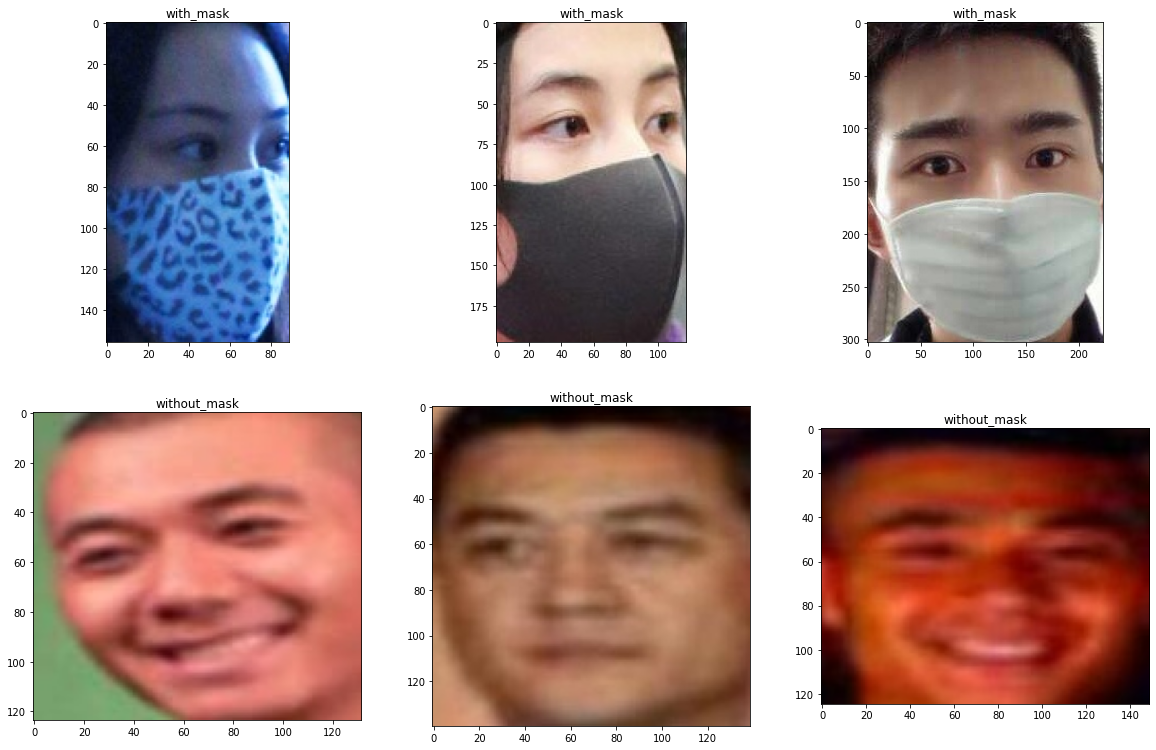

In [14]:
visualize_data(train_dir)

###Preprocessing data

We need to preprocess all the images. First of all we need to set a default image size (=224). We're going to use this size to match with the pretrained model which input is an image size (224,224,3)

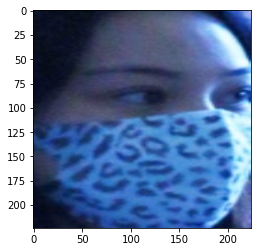

In [15]:
# Example with one image
img_size = 224
img = os.listdir(train_with_dir)[0]
img_array = cv2.imread(os.path.join(train_with_dir, img))
new_array = cv2.resize(img_array, (img_size, img_size))
plt.imshow(cv2.cvtColor(new_array, cv2.COLOR_BGR2RGB))

####Augmentation

In [16]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

####Creating training data

In [48]:
def create_data(dir, new_data):
  for category in classes:
    path = os.path.join(dir, category)
    class_num = classes.index(category) # 0,1 label
    for img in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path,img))
        new_array = cv2.resize(img_array, (224,224))
        new_data.append([new_array, class_num])
      except Exception as e:
        pass

  return random.shuffle(new_data)

In [51]:
training_data = []

def create_training_data():
  for category in classes:
    path = os.path.join(train_dir, category)
    class_num = classes.index(category) # 0,1 label
    for img in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path,img))
        new_array = cv2.resize(img_array, (224,224))
        training_data.append([new_array, class_num])
      except Exception as e:
        pass


In [52]:
testing_data = []

def create_test_data():
  for category in classes:
    path = os.path.join(test_dir, category)
    class_num = classes.index(category) # 0,1 label
    for img in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path,img))
        new_array = cv2.resize(img_array, (224,224))
        testing_data.append([new_array, class_num])
      except Exception as e:
        pass

In [53]:
create_training_data()
random.shuffle(training_data)
create_test_data()
random.shuffle(training_data)

In [56]:
def split_data(data):
  X = []
  y = []
  for features, label in data:
    X.append(features)
    y.append(label)
  X = np.array(X).reshape(-1, 224,224, 3)
  X = X/255.0
  y = np.array(y)
  return X, y

In [61]:
X_train, y_train = split_data(training_data)
X_test, y_test = split_data(testing_data)

##Creating the model

Pretrained model:

In [62]:
base_model = tf.keras.applications.mobilenet.MobileNet()

17227776/17225924 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

####Fine tuning

In [64]:
base_input = base_model.layers[0].input # the model starts at the pretrained model's first layer

In [65]:
base_output = base_model.layers[-4].output # cuts at the pretraining model's dropout layer

In [66]:
flatten_layer = layers.Flatten()(base_output) # connect this layer with base_input
final_output = layers.Dense(1)(flatten_layer) # connect with flatten_layer
                                              # the model classifies in 1 or 0 (with or without mask)
final_output = layers.Activation('sigmoid')(final_output) # add an activation function to the dense layer

In [67]:
model = keras.Model(inputs=base_input, outputs=final_output)

In [68]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in base_model.layers:
	layer.trainable = False

In [ ]:
model.summary()

##Compile the model

In [70]:
model.compile(loss = "binary_crossentropy", 
                  optimizer="adam",
                  metrics = ["accuracy"])

##Training the model

In [71]:
batch_size=32
epochs = 20
history = model.fit(
	aug.flow(X_train, y_train, batch_size=batch_size),
	steps_per_epoch=len(X_train) // batch_size,
	validation_data=(X_test, y_test),
	validation_steps=len(X_test) // batch_size,
	epochs=epochs)


Epoch 1/20
95/95 [==============================] - 60s 309ms/step - loss: 0.2268 - accuracy: 0.9212 - val_loss: 0.1398 - val_accuracy: 0.9513
Epoch 2/20
95/95 [==============================] - 28s 293ms/step - loss: 0.0943 - accuracy: 0.9733 - val_loss: 0.1209 - val_accuracy: 0.9539
Epoch 3/20
95/95 [==============================] - 28s 292ms/step - loss: 0.0794 - accuracy: 0.9756 - val_loss: 0.0938 - val_accuracy: 0.9684
Epoch 4/20
95/95 [==============================] - 28s 293ms/step - loss: 0.0611 - accuracy: 0.9835 - val_loss: 0.1038 - val_accuracy: 0.9645
Epoch 5/20
95/95 [==============================] - 28s 293ms/step - loss: 0.0558 - accuracy: 0.9825 - val_loss: 0.0895 - val_accuracy: 0.9711
Epoch 6/20
95/95 [==============================] - 28s 292ms/step - loss: 0.0473 - accuracy: 0.9852 - val_loss: 0.0744 - val_accuracy: 0.9776
Epoch 7/20
95/95 [==============================] - 28s 294ms/step - loss: 0.0432 - accuracy: 0.9885 - val_loss: 0.0676 - val_accuracy: 0.9789

Save the model

In [72]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [73]:
# my_model directory
!ls saved_model

# Contains an assets folder, saved_model.pb, and variables folder.
!ls saved_model/my_model

my_model  my_model.png
assets	keras_metadata.pb  saved_model.pb  variables


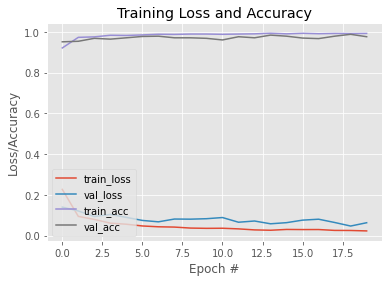

In [74]:
# plot the training loss and accuracy
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('saved_model/my_model')

##Predictions

Loading the model

In [ ]:
my_model = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
my_model.summary()

Evaluating the model

In [76]:
# Evaluate the restored model
loss, acc = my_model.evaluate(X_test, y_test, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

24/24 - 1s - loss: 0.0632 - accuracy: 0.9763
Restored model, accuracy: 97.63%


We're going to use [Haar Cascade Face Detection](https://github.com/opencv/opencv/tree/master/data/haarcascades) by OpenCV

In [77]:
def face_detection(path):
  image = cv2.imread(path)
  faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
  image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  faces = faceCascade.detectMultiScale(image_gray, 1.1, 4)
  for x,y,w,h in faces:
    only_face_gray = image_gray[y:y+h, x:x+w]
    only_face = image[y:y+h, x:x+w]
    cv2.rectangle(image, (x,y), (x+w, y+h), (0,255,255), 2)
    facess = faceCascade.detectMultiScale(only_face_gray)
    if len(facess) == 0:
      print("Face not detected!")
    else:
      for (ex,ey,ew,eh) in facess:
        cropped_face = only_face[ey:ey+eh, ex:ex+ew]

      final_image = cv2.resize(cropped_face, (224,224))
      final_image = np.expand_dims(final_image, axis=0)
      final_image = final_image/255.0

      cropped_face = cv2.resize(cropped_face, (224,224))

      font = cv2.FONT_HERSHEY_PLAIN # font to put text on the image

      prediction = my_model.predict(final_image)
      if prediction[0][0] < 0.5:
        print(f"With mask ({100 - round(prediction[0][0] * 100, 4)}%)")
        text = f"mask ({100 - round(prediction[0][0] * 100, 4)}%)"
        cv2.putText(cropped_face, text, (10,200), font, 1, (0, 255, 0), 1, cv2.LINE_AA)
        cv2.rectangle(image, (x,y), (x+w, y+h), (0,255,0), 2)
      else:
        print(f"Without mask ({round(prediction[0][0] * 100, 2)}%)")
        text = f"no mask ({round(prediction[0][0] * 100, 4)}%)"
        cv2.putText(cropped_face, text, (10,200), font, 1, (0, 0, 255), 1, cv2.LINE_AA)
        cv2.rectangle(image, (x,y), (x+w, y+h), (0,0,255), 2)
            
      # Plot two images
      plt.figure(figsize = (10,10))

      plt.subplot(1,2,1)
      plt.title('Full image')
      plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

      plt.subplot(1,2,2)
      plt.title('face_only')
      plt.imshow(cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB))


Face not detected!
With mask (99.1985%)
With mask (89.4559%)


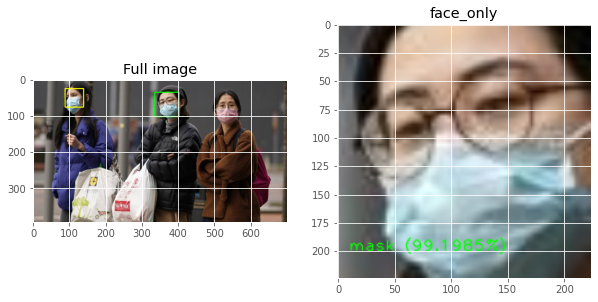

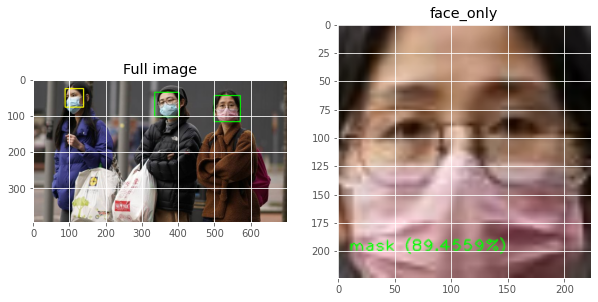

In [78]:
face_detection('/content/gdrive/My Drive/Kaggle/dataset/test1.jpg')

With mask (99.999%)


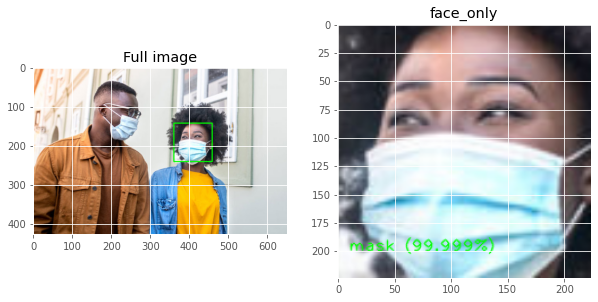

In [79]:
face_detection('/content/gdrive/My Drive/Kaggle/dataset/test2.jpg')

Face not detected!
With mask (86.6187%)
Face not detected!
With mask (98.5702%)
Face not detected!


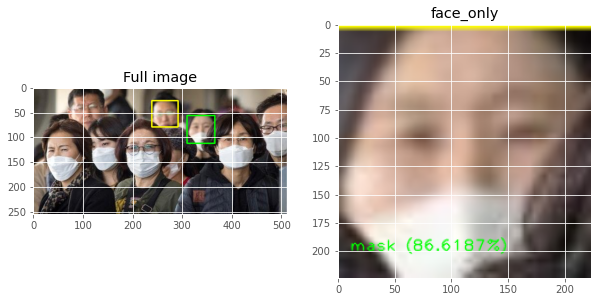

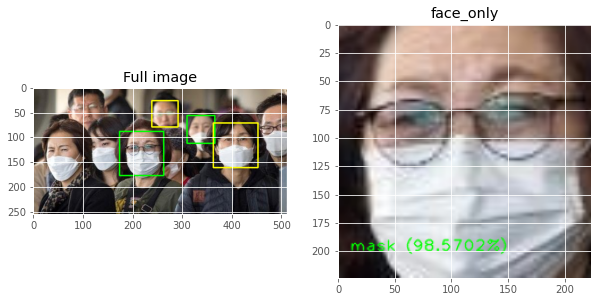

In [80]:
face_detection('/content/gdrive/My Drive/Kaggle/dataset/test3.jpg')

Without mask (99.99%)
With mask (99.9602%)
Face not detected!


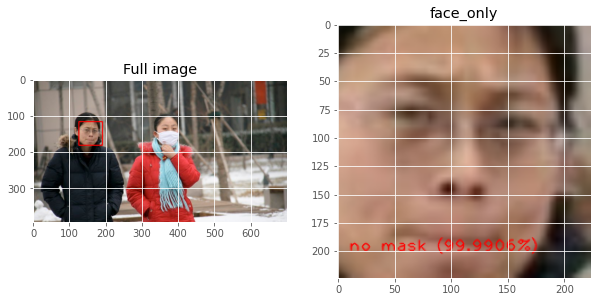

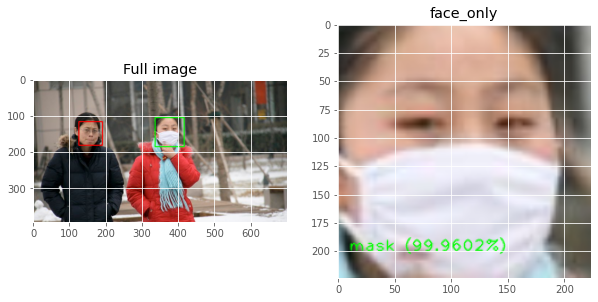

In [81]:
face_detection('/content/gdrive/My Drive/Kaggle/dataset/test4.jpg')

With mask (96.9869%)
With mask (98.9415%)


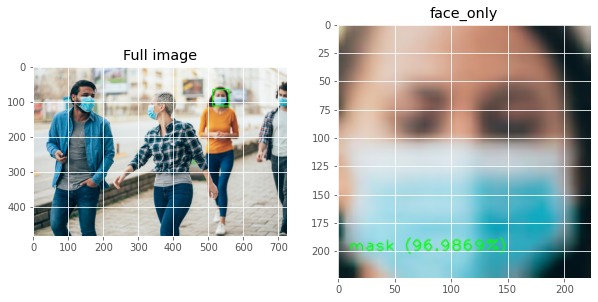

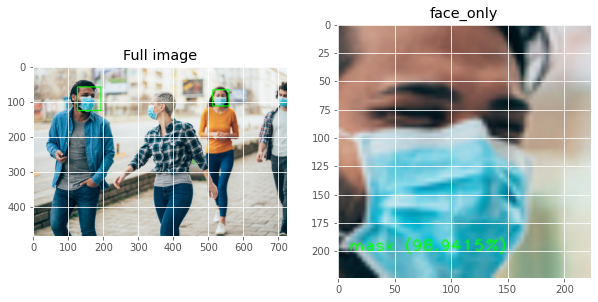

In [82]:
face_detection('/content/gdrive/My Drive/Kaggle/dataset/test5.jpg')